In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
     for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scrabble-player-rating/sample_submission.csv
/kaggle/input/scrabble-player-rating/games.csv
/kaggle/input/scrabble-player-rating/turns.csv
/kaggle/input/scrabble-player-rating/train.csv
/kaggle/input/scrabble-player-rating/test.csv


In [2]:
games=pd.read_csv('../input/scrabble-player-rating/games.csv')
sample_submission=pd.read_csv('../input/scrabble-player-rating/sample_submission.csv')
test=pd.read_csv('../input/scrabble-player-rating/test.csv')
train=pd.read_csv('../input/scrabble-player-rating/train.csv')
turns=pd.read_csv('../input/scrabble-player-rating/turns.csv')

In [3]:
games

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722
...,...,...,...,...,...,...,...,...,...,...,...,...
72768,72769,browndav,blitz,STANDARD,0,2022-09-07 13:24:13,CSW21,180,0,RATED,1,218.043751
72769,72770,HastyBot,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,3662.659287
72770,72771,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,236.133634
72771,72772,Gtowngrad,regular,STANDARD,0,2022-08-31 15:57:38,NWL20,900,0,RATED,1,681.370077


In [4]:
test

,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0
...,...,...,...,...
44721,72762,kyjo55555,367,NaN
44722,72768,HastyBot,524,2356.0
44723,72768,Maximilian,357,NaN
44724,72769,STEEBot,626,2110.0


In [5]:
train

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473
...,...,...,...,...
100815,72771,HastyBot,393,1614
100816,72772,BetterBot,442,1674
100817,72772,Gtowngrad,388,1364
100818,72773,adola,383,2075


In [6]:
turns.drop(['score','nickname'],axis=1,inplace=True)

**Data Cleaning**

In [7]:
def dataframeCleanup(df):
    df.drop_duplicates(subset="game_id",inplace=True)
    if(df.isna().sum().sum()>0 and df.isna().sum().sum()<20):
        df.dropna(inplace=True)
    else:
        df.fillna(0)
        
    return df
        

In [8]:
games_cleaned=dataframeCleanup(games)
turns_cleaned=dataframeCleanup(turns)
train_cleaned=dataframeCleanup(train)
test_cleaned=dataframeCleanup(test)

In [9]:
train_merged = train_cleaned.merge(turns_cleaned,on='game_id').merge(games_cleaned,on='game_id')
train_merged.info()
test_merged=test_cleaned.merge(turns_cleaned,on='game_id').merge(games_cleaned,on='game_id')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50410 entries, 0 to 50409
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                50410 non-null  int64  
 1   nickname               50410 non-null  object 
 2   score                  50410 non-null  int64  
 3   rating                 50410 non-null  int64  
 4   turn_number            50410 non-null  int64  
 5   rack                   50410 non-null  object 
 6   location               45853 non-null  object 
 7   move                   50405 non-null  object 
 8   points                 50410 non-null  int64  
 9   turn_type              50409 non-null  object 
 10  first                  50410 non-null  object 
 11  time_control_name      50410 non-null  object 
 12  game_end_reason        50410 non-null  object 
 13  winner                 50410 non-null  int64  
 14  created_at             50410 non-null  object 
 15  le

In [10]:
#train_merged.drop(['rating_x'], axis=1,inplace=True)

**Data Visualisation**

In [11]:
train_merged

,game_id,nickname,score,rating,turn_number,rack,location,move,points,turn_type,...,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,335,1637,1,DDEGITT,8G,DIG,10,Play,...,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,3,davidavid,440,1811,1,AJNOPQS,NaN,-JQ,0,Exchange,...,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
2,4,Inandoutworker,119,1473,1,ADEMSTX,8D,MAXED,36,Play,...,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
3,5,stevy,325,1500,1,DIILPST,8H,LIPID,20,Play,...,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722
4,6,HivinD,378,2029,1,DEEKNNO,8D,KENDO,30,Play,...,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,72767,HAYDEN,340,1395,1,AAILNSY,8H,INLAY,24,Play,...,regular,TIME,0,2022-09-05 04:35:56,CSW21,3600,0,CASUAL,1,3669.988413
50406,72770,HastyBot,590,2237,1,BEIINUW,8F,IWI,12,Play,...,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,3662.659287
50407,72771,BB-8,390,1500,1,ACDJNPR,8G,JAR,20,Play,...,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,236.133634
50408,72772,BetterBot,442,1674,1,?AEOSUY,8G,SOY,12,Play,...,regular,STANDARD,0,2022-08-31 15:57:38,NWL20,900,0,RATED,1,681.370077


In [12]:
def dataVisualisation(data,y,title):
    # fig,ax=plt.subplots(1,1,sharex=True,figsize=(10,10))
    # ax[0].set_title(title,fontsize=15)
    #sns.boxplot(data=data,x=y,ax=ax[0])
    sns.displot(data[y],kde=True)
    plt.axvline(data[y].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(data[y].mean(),1)) + ' ')
    plt.axvline(data[y].median(), color='red', linewidth=2.2, label='median='+ str(np.round(data[y].median(),1)) +' ')
    plt.axvline(data[y].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(data[y].mode()[0]) + ' ')
    plt.title(title)
    plt.legend()
    plt.show()
    

In [13]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50410 entries, 0 to 50409
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                50410 non-null  int64  
 1   nickname               50410 non-null  object 
 2   score                  50410 non-null  int64  
 3   rating                 50410 non-null  int64  
 4   turn_number            50410 non-null  int64  
 5   rack                   50410 non-null  object 
 6   location               45853 non-null  object 
 7   move                   50405 non-null  object 
 8   points                 50410 non-null  int64  
 9   turn_type              50409 non-null  object 
 10  first                  50410 non-null  object 
 11  time_control_name      50410 non-null  object 
 12  game_end_reason        50410 non-null  object 
 13  winner                 50410 non-null  int64  
 14  created_at             50410 non-null  object 
 15  le

In [14]:
#train_merged['nickname_x'].dtype

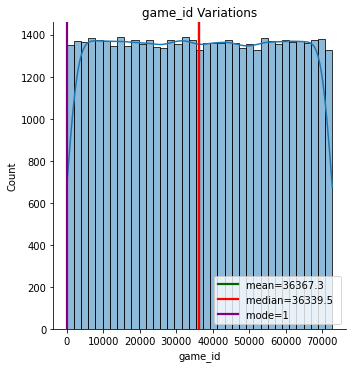

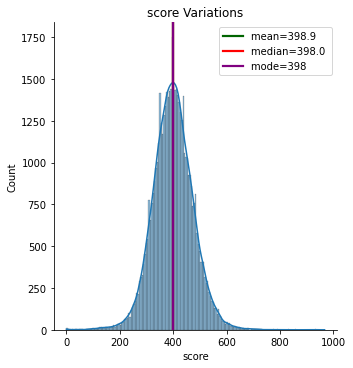

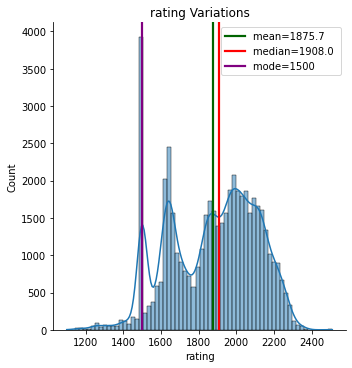

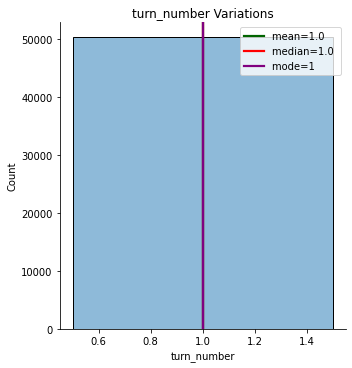

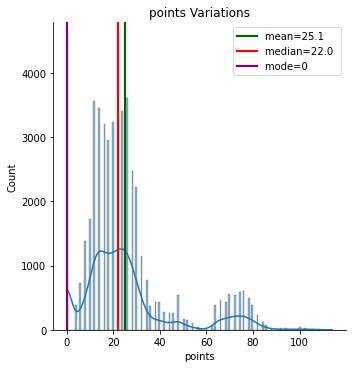

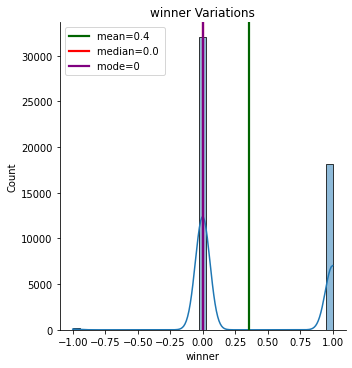

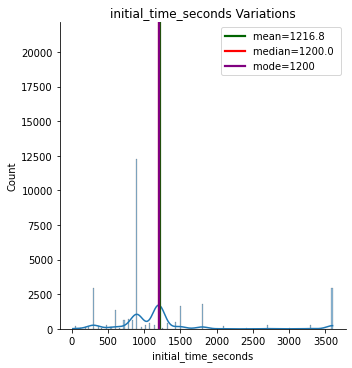

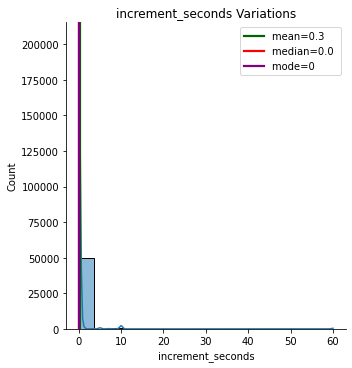

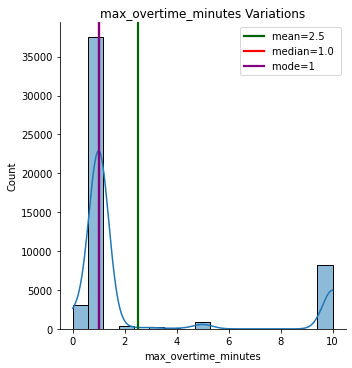

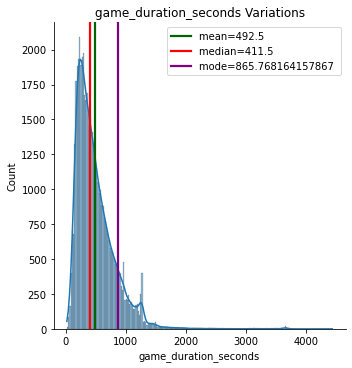

In [15]:
for col in train_merged.columns:
    if(not(train_merged[col].dtype=='object')):
       
        dataVisualisation(train_merged,col,col+" Variations")

In [16]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50410 entries, 0 to 50409
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                50410 non-null  int64  
 1   nickname               50410 non-null  object 
 2   score                  50410 non-null  int64  
 3   rating                 50410 non-null  int64  
 4   turn_number            50410 non-null  int64  
 5   rack                   50410 non-null  object 
 6   location               45853 non-null  object 
 7   move                   50405 non-null  object 
 8   points                 50410 non-null  int64  
 9   turn_type              50409 non-null  object 
 10  first                  50410 non-null  object 
 11  time_control_name      50410 non-null  object 
 12  game_end_reason        50410 non-null  object 
 13  winner                 50410 non-null  int64  
 14  created_at             50410 non-null  object 
 15  le

**Model**

In [17]:
train_X=train_merged[['game_id','score','points','game_duration_seconds']]
train_y=train_merged['rating']
train_X_copy=train_X.copy()



In [18]:
scaler=StandardScaler()
train_X_copy[['score','points','game_duration_seconds']]=scaler.fit_transform(train_X_copy[['score','points','game_duration_seconds']])


In [19]:
train_X_copy
#df=pd.DataFrame(train_X_scaled,columns=train_X.columns)

,game_id,score,points,game_duration_seconds
0,1,-0.851119,-0.757230,0.551731
1,3,0.546882,-1.260215,-0.000567
2,4,-3.727008,0.550532,-0.428327
3,5,-0.984262,-0.254245,0.454460
4,6,-0.278605,0.248741,-0.198155
...,...,...,...,...
50405,72767,-0.784548,-0.053050,9.612131
50406,72770,2.544027,-0.656633,9.589960
50407,72771,-0.118833,-0.254245,-0.775381
50408,72772,0.573511,-0.656633,0.571472


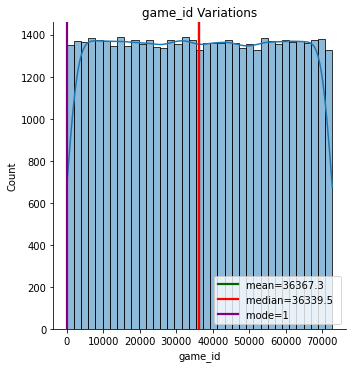

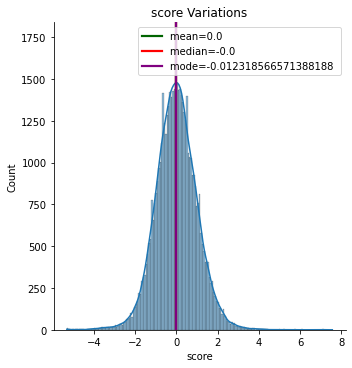

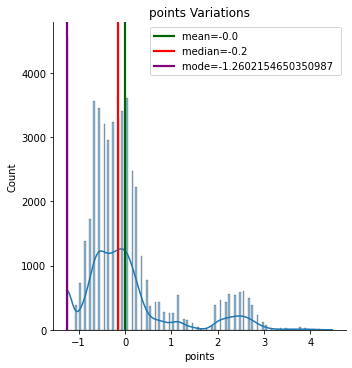

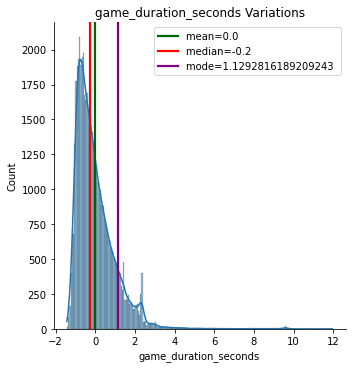

In [20]:
for col in train_X_copy.columns:
   
        dataVisualisation(train_X_copy,col,col+" Variations")

In [21]:
import xgboost as xgb

In [22]:
xgb_best = xgb.XGBRegressor(reg_lambda = 0.5667025244762842,
                   alpha = 0.0016428787046581727,
                   colsample_bytree = 0.9,
                   subsample = 0.4,
                   learning_rate = 0.05,
                   n_estimators = 2000,
                   max_depth = 7,
                   min_child_weight = 1)

In [23]:
xgb_best.fit(train_X_copy, train_y)

XGBRegressor(alpha=0.0016428787046581727, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.9, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.00164287875, ...)

In [24]:
test_X=test_merged[['game_id','score','points','game_duration_seconds']]
test_y=test_merged['rating']


In [25]:

test_X[['score','points','game_duration_seconds']]=scaler.fit_transform(test_X[['score','points','game_duration_seconds']])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [26]:
predict_test_y=xgb_best.predict(test_X)
predict_test_y

array([2087.4963, 1984.9706, 1745.0681, ..., 1658.9948, 1873.3179,
       1877.7697], dtype=float32)

In [27]:
test_y.fillna(0,inplace=True)
test_y=test_y.values
test_y

array([   0., 2082., 1829., ..., 1710., 2356., 2110.])

In [28]:
len(test_y)


22363

In [29]:
len(predict_test_y)

22363

In [30]:
mean_absolute_error(test_y,predict_test_y)

1007.8552031080129

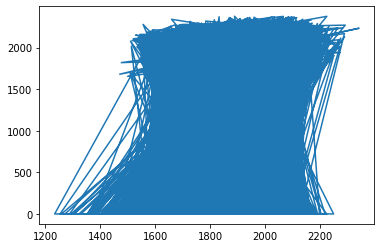

In [31]:
plt.plot(predict_test_y,test_y)


In [32]:
final_df=pd.DataFrame({"game_id":test_X['game_id'],"rating":predict_test_y})

In [33]:
final_df

,game_id,rating
0,2,2087.496338
1,7,1984.970581
2,11,1745.068115
3,14,2152.723389
4,27,2198.595947
...,...,...
22358,72760,1780.594849
22359,72761,1567.271362
22360,72762,1658.994751
22361,72768,1873.317871


In [34]:
final_df.to_csv('submission.csv')